In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '8'
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
from quspin.tools.evolution import expm_multiply_parallel
from quspin.operators import quantum_LinearOperator
from quspin.operators import quantum_operator
plt.rcParams['figure.figsize'] = [10, 8]
import matplotlib.ticker as ticker

In [2]:
def simulate(Tf, N, ein, m, Tsteps, PBC, trotter_steps=-1):

    T = Tf/m
    dt = T/Tsteps
    times = np.arange(0,T,dt)

    g = (ein**2)/(2)

    N_filled = N // 2
    E_neg1 = 0
    P_neg1 = np.exp(-1j * E_neg1)
    t = -0.5

    spin_basis = spin_basis_1d(N, pauli=-1, Nup=N_filled)
    spin_basis_m1 = spin_basis_1d(N, pauli=-1, Nup=N_filled-1)
    basis_full = spin_basis_1d(N, pauli=-1)

    ### E-field term
    def E_squared(n, g_in, E_neg1):
        E_const = (E_neg1 / max(1e-8, np.sqrt(g_in * 2))) - (n + 1) // 2
        s_coupling = []
        d_coupling = []
        for i in range(n + 1):
            s_coeff = E_const * g_in
            s_coupling += [[s_coeff, i]]
            for j in range(n + 1):
                d_coeff = 0.5 * g_in
                d_coupling += [[d_coeff, i, j]]
        return [["n", s_coupling], ["nn", d_coupling]]

    def shortest_path(n_in, m_in, N_in):
        return np.min([np.abs(n_in - m_in), N_in - np.abs(n_in - m_in)])

    def coupling(distance, N_in):
        if distance < 2:
            return distance
        elif distance == N_in // 2:
            return (N_in ** 2 - 8) / (4 * (N_in - 3))
        else:
            return distance + (distance ** 2 - 3 * distance + 2) / (3 - N_in)
    def U1spinH(g_in, t_in, m_in, N_in, N_filled_in, PBC_in, E_neg1=0, Hbasis=spin_basis, trotter=False):
        P_neg1 = np.exp(-1j * E_neg1)
        static_terms = []
        dynamic_terms = []
        
        H_list = []

        ### Hopping term
        L = (N_in if PBC else N_in - 1)
        hop_coupling = [[t_in, i, (i+1) % N_in] for i in range(N_in)]
        hop_coupling_dag = [[t_in, (i+1) % N_in, i] for i in range(N_in)]
        if PBC and N_filled_in % 2 == 0:
            hop_coupling[-1][0] = -hop_coupling[-1][0]
            hop_coupling_dag[-1][0] = -hop_coupling_dag[-1][0]
        if not trotter:
            static_terms += [["+-", hop_coupling]]
            static_terms += [["+-", hop_coupling_dag]]
        else:
            for c in hop_coupling:
                H_list.append(hamiltonian([["+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))
            for c in hop_coupling_dag:
                H_list.append(hamiltonian([["+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))

        ### Mass term
        mass_coupling = [[-m_in * (-1) ** i, i, i] for i in range(N_in)]
        if not trotter:
            static_terms += [["+-", mass_coupling]]
        else:
            for c in mass_coupling:
                H_list.append(hamiltonian([["+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))
        

        ### E-field term
        if PBC:
            E_longrange_general = np.zeros((N_in,N_in))
            for n in range(N_in):
                for k in range(N_in):
                    E_longrange_general[n,k] = coupling(shortest_path(n, k, N_in), N_in)
            E_longrange_general = -0.25 * (N_in - 3) / (N_in - 2) * E_longrange_general

            E_longrange = [[2 * g_in * E_longrange_general[i,j],i,i,j,j] for i in range(N_in) for j in range(N_in)] # from gauss' law

            E_onsite_general = np.zeros(N_in)
            for n in range(N_in):
                for m in range(N_in):
                    if (m%2==1):
                        E_onsite_general[n] += coupling(shortest_path(n, m, N_in), N_in) + coupling(shortest_path(m, n, N_in), N_in)

            E_onsite = [[-2 * g_in * E_onsite_general[i],i,i] for i in range(N)]
            
            if not trotter:
                static_terms += [["+-+-",E_longrange],["+-",E_onsite]]
            else:
                for c in E_longrange:
                    H_list.append(hamiltonian([["+-+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))
                for c in E_onsite:
                    H_list.append(hamiltonian([["+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))
        else:
            for i in range(L):
                if not trotter:
                    static_terms += E_squared(i, -g_in, E_neg1)
                else:
                    E_const = (E_neg1 / max(1e-8, np.sqrt(g_in * 2))) - (i + 1) // 2
                    s_coupling = []
                    d_coupling = []
                    for k in range(i + 1):
                        s_coeff = E_const * g_in
                        s_coupling += [[s_coeff, k,k]]
                        for j in range(k + 1):
                            d_coeff = 0.5 * g_in
                            d_coupling += [[d_coeff, k,k,j,j]]
                    for c in s_coupling:
                        H_list.append(hamiltonian([["+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))
                    for c in d_coupling:
                        H_list.append(hamiltonian([["+-+-", [c]]], dynamic_terms, basis=Hbasis, dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False))

        if not trotter:
            return hamiltonian(static_terms, dynamic_terms, basis=Hbasis, dtype=np.float64)
        else:
            return H_list

    ###################################################### RTD GROUND STATE PREP #################################################


    H_init = U1spinH(g, t, m, N, N_filled, PBC)    
    E_init,V_init=H_init.eigsh(k=1,which='SA',maxiter=1e8)
    psi_i = V_init[:,0]
    psi_i = psi_i.reshape((-1,))
    del H_init

    ###################################################### RTD TIME EVOLN & LOSCHMIDT ############################################

    if trotter_steps < 1:
        H = U1spinH(g, t, -m, N, N_filled, PBC)
#         print(H.toarray())
        ##### define data type for the simulation
        dtype_real = np.float64
        dtype_cmplx = np.result_type(dtype_real,np.complex64)
        # pre assign arrays
        Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
        # construct piece-wise constant unitaries
        expH = expm_multiply_parallel(H.tocsr(),a=-1j*dt,dtype=dtype_cmplx)
        # auxiliary array for memory efficiency
        psi=psi_i.copy().astype(np.complex128)
        work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
        # prepare output
        loschmidt = []
        for i in range(len(times)):
            #if i % (len(times)//10) == 0:
                #print("# T = ",times[i])
            Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
            #print(f"{times[i]}\t {Lt[i]}")
            loschmidt += [Lt[i]]
            expH.dot(psi,work_array=work_array,overwrite_v=True)
        
        # END of time evolution
    else:
        Hlist = U1spinH(g, t, -m, N, N_filled, PBC, trotter=True)
             ##### define data type for the simulation
        dtype_real = np.float64
        dtype_cmplx = np.result_type(dtype_real,np.complex64)
        # pre assign arrays
        Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
        # auxiliary array for memory efficiency
        psi=psi_i.copy().astype(np.complex128)
        work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
        # prepare output
        loschmidt = []
        for i in range(len(times)):
            psi=psi_i.copy().astype(np.complex128)
            for j in range(trotter_steps):
                for h in Hlist:
                    expH = expm_multiply_parallel(h.tocsr(),a=-1j*dt*i/trotter_steps,dtype=dtype_cmplx)
                    expH.dot(psi,work_array=work_array,overwrite_v=True)
            #if i % (len(times)//10) == 0:
                #print("# T = ",times[i])
            Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
            #print(f"{times[i]}\t {Lt[i]}")
            loschmidt += [Lt[i]]
        
        # END of time evolution

    ###################################################### CORRELATOR CALCULATION #################################################
    
    basis_fermion = spinless_fermion_basis_1d(L=N)
    def c_operator(n):
        cdag_static = [["z" * n + "-", [[(-1) ** n] + list(range(n+1))]]]
        cdagn = quantum_LinearOperator(cdag_static,basis=basis_full,dtype=np.complex128,check_herm=False,check_pcon=False,check_symm=False)
        return(cdagn)
#     def c_operator(n):
#         cdag_static = [["-",[[1.0,n]]]]
#         cdagn = quantum_LinearOperator(cdag_static,basis=basis_fermion,dtype=np.complex128,check_herm=False,check_pcon=False,check_symm=False)
#         return(cdagn)
    annihilators = [c_operator(n) for n in range(N)]
#     for i in range(N):
#         plt.imshow(np.abs(annihilators[i].matmat(np.eye(16))))
#         plt.colorbar()
#         plt.show()
#         plt.imshow(np.angle(annihilators[i].matmat(np.eye(16))))
#         plt.colorbar()
#         plt.show()

    ##### define data type for the simulation
    dtype_real = np.float64
    dtype_cmplx = np.result_type(dtype_real,np.complex64)

    # array to store correlators expectations from psi(t,n) to psi(0,0)
    correlators = np.zeros((N,len(times)),dtype=np.complex128)

    if trotter_steps < 1:

        P_Nhalf = spin_basis.get_proj(dtype=np.float64)
        P_Nhalfminus1 = spin_basis_m1.get_proj(dtype=np.float64)

        H_NHalf_m1 = U1spinH(g, t, -m, N, N_filled-1, PBC, Hbasis=spin_basis_m1).tocsr()
        H_NHalf = U1spinH(g, t, -m, N, N_filled, PBC, Hbasis=spin_basis).tocsr()

        for n in range(0, N, 2): #loop over all site pairings
            for i in range(len(times)): #loop over times (for annhilator location)
                # Even Correlators
                leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
                rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

                expmiH = expm_multiply_parallel(H_NHalf_m1,a=1j*dt*i,dtype=dtype_cmplx)
                expiH = expm_multiply_parallel(H_NHalf,a=-1j*dt*i,dtype=dtype_cmplx)

                expiH.dot(leftPsi,overwrite_v=True)
                tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n].dot(P_Nhalf.dot(leftPsi)))
                expmiH.dot(tempLpsi,overwrite_v=True)

                tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[0].dot(P_Nhalf.dot(rightPsi)))

                correlators[n,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>

                # Odd Correlators
                leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
                rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

                expiH.dot(leftPsi,overwrite_v=True) 
                tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n+1].dot(P_Nhalf.dot(leftPsi)))
                expmiH.dot(tempLpsi,overwrite_v=True)

                tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[1].dot(P_Nhalf.dot(rightPsi)))

                correlators[n+1,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>

    else:

        P_Nhalf = spin_basis.get_proj(dtype=np.float64)
        P_Nhalfminus1 = spin_basis_m1.get_proj(dtype=np.float64)

        H_NHalf_m1_s = U1spinH(g, t, -m, N, N_filled-1, PBC, Hbasis=spin_basis_m1, trotter=True)
        H_NHalf_s = U1spinH(g, t, -m, N, N_filled, PBC, Hbasis=spin_basis, trotter=True)

        for n in range(0, N, 2): #loop over all site pairings
            for i in range(len(times)): #loop over times (for annhilator location)
                # Even Correlators
                leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
                rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

                t_dt = dt * i / trotter_steps
                for t_step in range(trotter_steps):
                    for h in range(len(H_NHalf_m1_s)):
                        expiH = expm_multiply_parallel(H_NHalf_s[h].tocsr(),a=-1j*t_dt,dtype=dtype_cmplx)
                        expiH.dot(leftPsi,overwrite_v=True)
                    
                tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n].dot(P_Nhalf.dot(leftPsi)))
                
                t_dt = dt * i / trotter_steps
                for t_step in range(trotter_steps):
                    for h in range(len(H_NHalf_m1_s)):
                        expmiH = expm_multiply_parallel(H_NHalf_m1_s[h].tocsr(),a=1j*t_dt,dtype=dtype_cmplx)
                        expmiH.dot(tempLpsi,overwrite_v=True)

                tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[0].dot(P_Nhalf.dot(rightPsi)))

                correlators[n,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>

                # Odd Correlators
                leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
                rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

                
                t_dt = dt * i / trotter_steps
                for t_step in range(trotter_steps):
                    for h in range(len(H_NHalf_m1_s)):
                        expiH = expm_multiply_parallel(H_NHalf_s[h].tocsr(),a=-1j*t_dt,dtype=dtype_cmplx)
                        expiH.dot(leftPsi,overwrite_v=True)
                    
                tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n+1].dot(P_Nhalf.dot(leftPsi)))
                
                t_dt = dt * i / trotter_steps
                for t_step in range(trotter_steps):
                    for h in range(len(H_NHalf_m1_s)):
                        expmiH = expm_multiply_parallel(H_NHalf_m1_s[h].tocsr(),a=1j*t_dt,dtype=dtype_cmplx)
                        expmiH.dot(tempLpsi,overwrite_v=True)

                tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[1].dot(P_Nhalf.dot(rightPsi)))

                correlators[n+1,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
                
    correlatorfft = []
    for i in range(len(correlators[0, :])):
        fftsum = np.fft.fft(correlators[::2,i]) + np.fft.fft(correlators[1::2,i])
        correlatorfft.append(fftsum)
        
    correlatorfft = np.array(correlatorfft)

    ###################################################### NU CALCULATION ##########################################################

    t_slices, k_modes = np.shape(correlatorfft)
    dphi_k = np.zeros((t_slices-1, k_modes))
    dphi_t = np.zeros((t_slices-1, k_modes))
    for t in range(t_slices-1):
        for k in range(k_modes):
            dphi_k[t, k] = np.angle(correlatorfft[t, (k+1)%k_modes]/correlatorfft[t, k])
            dphi_t[t, k] = np.angle(correlatorfft[t + 1, k]/correlatorfft[t, k])
            
    finite_full = np.zeros((t_slices - 2, k_modes))
    for t in range(t_slices-2):
        for k in range(k_modes):
            finite_full[t, k] = (dphi_k[t, k] + dphi_t[t, (k+1)%k_modes]) - (dphi_k[t+1, k] + dphi_t[t, k])
    finite_left = np.zeros(t_slices-2)
    finite_right = np.zeros(t_slices-2)
    for k in range(k_modes//2):
        finite_left += finite_full[:,k]/2/np.pi
        finite_right += finite_full[:,k+k_modes//2]/2/np.pi
    n_left = []
    n_right = []
    for t in range(t_slices-2):
        ntau_left = 0
        ntau_right = 0
        for tau in range(0,t):
            ntau_left += finite_left[tau]
            ntau_right += finite_right[tau]
        n_left.append(ntau_left)
        n_right.append(ntau_right)
    n_left = np.array(n_left)
    n_right = np.array(n_right)

    return((-n_left+n_right, loschmidt))

In [3]:
Ninput = 4

minput = .8

PBCinput = True
tsteps_input = 1

Tf = 2
timesteps = 40
esteps = 40

einit = 0
ef = 2*minput
de = ef/esteps
evals = [de*i for i in range(esteps)]

titleinfo = ("Spin|N={:.0f}, m={:.1f}, Periodic, Dim=({:},{:}), Trotters={:} ".format(Ninput,minput,timesteps,esteps,tsteps_input) if PBCinput
             else "Spin|N={:.0f}, m={:.1f}, Fixed, Dim=({:},{:}), Trotters={:} ".format(Ninput,minput,timesteps,esteps,tsteps_input))

In [4]:
Loschmidts = np.zeros((timesteps,esteps))
nuvals = np.zeros((timesteps-2,esteps))
for k in range(esteps):
    tempvecNu,tempvecL = simulate(Tf,Ninput,evals[k],minput,timesteps,PBCinput,trotter_steps=tsteps_input)
    tempvecL = np.flip(tempvecL)
    tempvecNu = np.flip(tempvecNu)
    Loschmidts[:,k] = tempvecL
    nuvals[:,k] = tempvecNu
    print("--------------------------------------------------------------------------------------------------------")
    print("Done with " + str(k+1) +" of " + str(esteps) + " (" + str(round((k+1)/esteps*100,2)) + "%)")
    print("--------------------------------------------------------------------------------------------------------")


Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
--------------------------------------------------------------------------------------------------------
Done with 1 of 40 (2.5%)
--------------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
--------------------------------------------------------------------------------------------------------
Done with 2 of 40 (5.0%)
--------------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
--------------------------------------------------------------------------------------------------------
Done with 3 of 40 (7.5%)
--------------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry ch

--------------------------------------------------------------------------------------------------------
Done with 27 of 40 (67.5%)
--------------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
--------------------------------------------------------------------------------------------------------
Done with 28 of 40 (70.0%)
--------------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
--------------------------------------------------------------------------------------------------------
Done with 29 of 40 (72.5%)
--------------------------------------------------------------------------------------------------------
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
-------------------------------

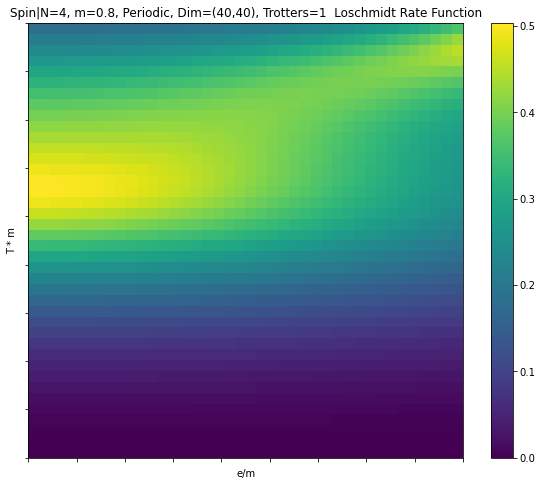

In [5]:
fig,ax = plt.subplots()
plt.ylabel("T * m")
plt.xlabel("e/m")
plt.title(titleinfo + " Loschmidt Rate Function")

im = ax.imshow(Loschmidts,aspect=esteps/timesteps)
ax.figure.colorbar(im,ax=ax)

x_tickcount=10
xticks = np.round(np.linspace(einit/minput,ef/minput,x_tickcount), 1)
ax.set_xticks(np.arange(x_tickcount))
ax.set_xticklabels(xticks)
ax.xaxis.set_major_locator(ticker.LinearLocator(x_tickcount))

y_tickcount=10
yticks=np.flip(np.round(np.linspace(0,Tf,y_tickcount), 1))
ax.set_yticks(np.arange(y_tickcount))
ax.set_yticklabels(yticks)
ax.yaxis.set_major_locator(ticker.LinearLocator(y_tickcount))

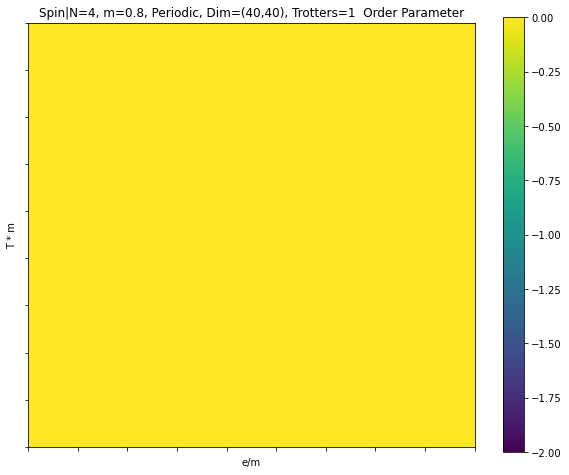

In [6]:
fig,ax = plt.subplots()
plt.ylabel("T * m")
plt.xlabel("e/m")
plt.title(titleinfo + " Order Parameter")

im = ax.imshow(nuvals,aspect=esteps/timesteps,vmin=-2)
ax.figure.colorbar(im,ax=ax)

x_tickcount=10
xticks = np.round(np.linspace(einit/minput,ef/minput,x_tickcount), 1)
ax.set_xticks(np.arange(x_tickcount))
ax.set_xticklabels(xticks)
ax.xaxis.set_major_locator(ticker.LinearLocator(x_tickcount))

y_tickcount=10
yticks=np.flip(np.round(np.linspace(0,Tf,y_tickcount), 1))
ax.set_yticks(np.arange(y_tickcount))
ax.set_yticklabels(yticks)
ax.yaxis.set_major_locator(ticker.LinearLocator(y_tickcount))
